In [1]:
import os
import yaml
import copy
import pickle
import ml_collections
import wandb, signatory

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path as pt
from tqdm import tqdm
sns.set_style("darkgrid")  # 원하는 스타일 선택

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import *
from src.evaluation.summary import full_evaluation

In [2]:
import os
import yaml
import copy
import pickle
import ml_collections
import wandb, signatory

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import path as pt
from tqdm import tqdm
sns.set_style("darkgrid")  # 원하는 스타일 선택

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from src.utils import *
from src.evaluation.summary import full_evaluation

In [3]:
# Load configuration dict
config_dir = 'configs/config.yaml'
with open(config_dir) as file:
    config = ml_collections.ConfigDict(yaml.safe_load(file))
    
torch.cuda.set_device(1)
if (config.device == "cuda" and torch.cuda.is_available()):
    config.update({"device": "cuda:1"}, allow_val_change=True)    
else:
    config.update({"device": "cpu"}, allow_val_change=True)

set_seed(1)

### Data Preprocess

In [4]:
def rolling_window(data, window_size):
    n_windows = data.shape[0] - window_size + 1
    windows = np.zeros((n_windows, window_size, data.shape[1]))
    for idx in range(n_windows):
        windows[idx] = data[idx:idx + window_size]
    return windows

# Step 1: Load and preprocess data
df = pd.read_csv("./data/indices.csv")
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df.set_index('Date', inplace=True)
df = df.apply(pd.to_numeric).astype(float)
#df.drop(columns='Hang Seng', inplace=True)


# Step 2: Compute log 4
log_returns = np.diff(np.log(df), axis=0)
print(log_returns.shape)

# Step 3: Scale the log returns
log_returns_scaled, scalers = scaling(log_returns)

# Step 4: Prepare initial prices and create rolling windows
init_price = torch.from_numpy(np.array(df)[:-(config.n_steps), :]).float().unsqueeze(1)
log_returns_scaled = torch.from_numpy(rolling_window(log_returns_scaled, config.n_steps)).float()
log_returns_org = torch.from_numpy(rolling_window(log_returns, config.n_steps)).float()
print('log_returns_scaled:', log_returns_scaled.shape)

(6189, 6)
log_returns_scaled: torch.Size([5934, 256, 6])


### Log Return Path

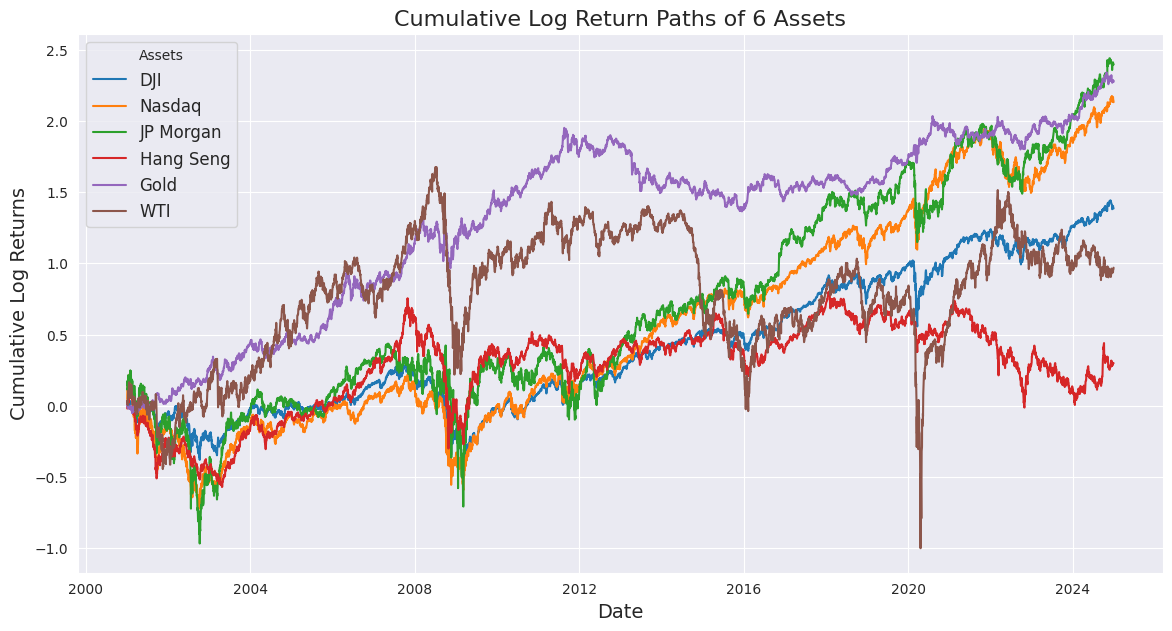

In [5]:
# Step 3: Compute cumulative log returns
cumulative_log_returns = np.cumsum(log_returns, axis=0)

# Step 4: Create a DataFrame for cumulative log returns
cumulative_log_returns_df = pd.DataFrame(
    cumulative_log_returns,
    index=df.index[1:],  # Adjust index for cumulative log returns
    columns=df.columns
)

# Step 5: Plot the cumulative log return paths
plt.figure(figsize=(14, 7))
for col in cumulative_log_returns_df.columns:
    plt.plot(cumulative_log_returns_df.index, cumulative_log_returns_df[col], label=col)

plt.title("Cumulative Log Return Paths of 6 Assets", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Cumulative Log Returns", fontsize=14)
plt.legend(title="Assets", fontsize=12)
plt.grid(True)
plt.show()


### Generative models for time series generation

### Data Construction

We divide the data into training and validation set for the offline evaluation of our model

In [6]:
train_size = int(log_returns_scaled.shape[0] * 0.7)

training_data = log_returns_scaled[:train_size]
test_data = log_returns_scaled[train_size:]

train_init_price = init_price[:train_size]

training_data_org = log_returns_org[:train_size]
test_data_org = log_returns_org[train_size:]

print("training_data: ", training_data.shape)
print("test_data: ", test_data.shape)

training_data:  torch.Size([4153, 256, 6])
test_data:  torch.Size([1781, 256, 6])


Load the dataset


In [7]:
training_set = TensorDataset(training_data)
test_set = TensorDataset(test_data)

train_dl = DataLoader(training_set, batch_size=config.batch_size, shuffle=True)
test_dl = DataLoader(test_set, batch_size=config.batch_size, shuffle=True)

### Generative model

### Initialize the generator, discriminator and the trainer

In [8]:
from src.baselines.networks.discriminators import TCNDiscriminator
from src.baselines.networks.generators import TCNGenerator
from src.baselines.trainer import *

generators = {}
discriminators = {}

for i in range(config.n_vars):
    generators[i] = TCNGenerator(config).to(config.device)
    discriminators[i] = TCNDiscriminator(config).to(config.device)
trainer = GANTrainer(G=generators, D=discriminators, train_dl=train_dl, config=config)


Generator[0] 구조 및 파라미터:
  tcn.0.conv1.weight                              256
  tcn.0.conv1.bias                                 64
  tcn.0.relu1.weight                                1
  tcn.0.bn1.weight                                 64
  tcn.0.bn1.bias                                   64
  tcn.0.conv2.weight                            4,096
  tcn.0.conv2.bias                                 64
  tcn.0.relu2.weight                                1
  tcn.0.bn2.weight                                 64
  tcn.0.bn2.bias                                   64
  tcn.0.downsample.0.weight                       256
  tcn.0.downsample.0.bias                          64
  tcn.0.relu.weight                                 1
  tcn.1.conv1.weight                            8,192
  tcn.1.conv1.bias                                 64
  tcn.1.relu1.weight                                1
  tcn.1.bn1.weight                                 64
  tcn.1.bn1.bias                                   64
  t

### Model training and saving

In [9]:
# # Model training
#trainer.fit()

# Model Evaluation

### MVFIT-GAN

In [10]:
from scipy.stats import entropy, wasserstein_distance, ks_2samp, spearmanr, kendalltau
from statsmodels.tsa.stattools import acf
from scipy.spatial.distance import jensenshannon

full_name = "*42_300_256_Glr_0.0002_Dlr_0.0001_hidden_dim_64_n_steps_256_corr_loss_l1_corr_weight_0.05_f_epoch_40_n_critic_2_gp_10.0_noise_4_Adam_drop_0.0_0.2_8_splitupdate_v2_corrlinear_overall_Adam0.5"

In [11]:
""" Find the best epochs based on 100 days cumulative distribution """

from src.baselines.networks.generators import TCNGenerator
#gen_tmp = Generator(config)
min_dist = float('inf')  
best_epoch = 0

# rolling window 크기 (예: 100 days)
window = 100

def compute_avg_emd(real_data, fake_data, window):
    """
    real_data, fake_data: 각각 shape (batch, 1, time)
    각 창(window)마다의 합계를 구하고, 두 분포 간의 Earth Mover's Distance (EMD)를 구하여 합산합니다.
    """
    emd = 0
    # real_data.shape[1]가 1이더라도, loop로 general하게 처리 (만약 다중 feature인 경우 대비)
    for i in range(real_data.shape[1]):
        real_dist = rolling_window(real_data[:, i, :].T, window).sum(axis=1).ravel()
        fake_dist = rolling_window(fake_data[:, i, :].T, window).sum(axis=1).ravel()
        emd += wasserstein_distance(real_dist, fake_dist)
    return emd

def load_sub_generator(file_path, config):
    """
    TCNGenerator를 이용해 저장된 모델을 불러오고, device에 올린 후 eval 모드로 전환합니다.
    """
    sub_gen = TCNGenerator(config)
    sub_gen.load_state_dict(torch.load(file_path, map_location=config.device))
    return sub_gen.to(config.device).eval()

# 검사할 에폭 범위 (예: 70부터 90까지 2 에폭 간격으로 평가)
epochs_to_check = range(160, 162, 2)

# 각 서브 생성자별 최소 EMD와 베스트 에폭 초기화
min_emd = [float('inf')] * config.n_vars
best_epoch = [None] * config.n_vars

# 실제 데이터 로딩: training_data_org는 (batch, time, n_vars) 형태라고 가정하며,
real_data = training_data_org.transpose(1, 2).cpu().numpy()


# Generator 평가에 사용할 노이즈 생성 (예시: 3000 샘플)
noise = torch.randn(3000, config.noise_dim, config.n_steps).to(config.device)

# 각 에폭마다 각 서브 생성자(변수별)를 평가
for epoch in epochs_to_check:

    for i in range(config.n_vars):
        # 저장된 모델의 경로 구성 (예전에 저장했던 경로와 파일명이 일치해야 합니다.)
        file_path = os.path.join(f'./results/models/{full_name}/', f"Generator_{epoch}_var_{i}.pt")
        # 파일이 존재하지 않으면 continue
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            continue
        
        # 서브 생성자 로딩
        sub_gen = load_sub_generator(file_path, config)        
        with torch.no_grad():
            fake = sub_gen(noise)  # fake의 shape는 (batch, 1, time) 이어야 합니다.
        
        # inverse_scaling_split 함수로 후처리 (scalers 및 변수 i에 맞게 진행)
        fake_data = inverse_scaling_split(fake, scalers, i)  # scalers가 미리 정의되어 있어야 합니다.
        
        # 실제 데이터와 fake 데이터의 EMD 계산 (각 변수별로)
        emd_val = compute_avg_emd(real_data[:, i:i+1, :], fake_data, window)
        if emd_val < min_emd[i]:
            min_emd[i] = emd_val
            best_epoch[i] = epoch
    
    print(f"Epoch {epoch}: best_epoch = {best_epoch}, min_emd = {min_emd}")

print("\n--- 최종 결과: 각 서브 생성자별 Best Epoch ---")
for i in range(config.n_vars):
    print(f"SubGen {i}: best epoch = {best_epoch[i]}, EMD = {min_emd[i]:.3f}")

Epoch 160: best_epoch = [160, 160, 160, 160, 160, 160], min_emd = [0.025541231143669876, 0.01712423575599412, 0.05689153377006152, 0.02590863035879946, 0.008259930739230325, 0.02779590436383517]

--- 최종 결과: 각 서브 생성자별 Best Epoch ---
SubGen 0: best epoch = 160, EMD = 0.026
SubGen 1: best epoch = 160, EMD = 0.017
SubGen 2: best epoch = 160, EMD = 0.057
SubGen 3: best epoch = 160, EMD = 0.026
SubGen 4: best epoch = 160, EMD = 0.008
SubGen 5: best epoch = 160, EMD = 0.028


In [12]:
real_data = training_data_org.transpose(1, 2).cpu().numpy()
# best_epoch[0] = 162
# best_epoch[1] = 174
# best_epoch[2] = 162
# best_epoch[3] = 194
# best_epoch[4] = 164
# best_epoch[5] = 184



# For Correlation Heatmap
best_epoch[0] = 216
best_epoch[1] = 174
best_epoch[2] = 186
best_epoch[3] = 194
best_epoch[4] = 164
best_epoch[5] = 184


fake_series_list = []
for i in range(config.n_vars):    
    best_ep = best_epoch[i]  # 각 서브 생성자의 가장 좋은 에폭  
    file_path = os.path.join(f'./results/models/{full_name}/', f"Generator_{best_ep}_var_{i}.pt")
    
    # 서브 생성자 로딩: 수정된 load_sub_generator 함수 호출 (TCNGenerator 파라미터 제거)
    sub_gen = load_sub_generator(file_path, config)
    
    with torch.no_grad():
        # fake의 shape: (batch, 1, n_steps)
        fake = sub_gen(noise)
    
    # scalers[i]를 적용하여 inverse scaling 진행 (출력이 (batch, 1, n_steps) 형태임)
    fake_data_i = inverse_scaling_split(fake, scalers, i)
    # 필요 시 numpy array를 torch.Tensor로 변환 (device 및 dtype 맞춤)
    fake_data_i = torch.tensor(fake_data_i, device=config.device)
    
    fake_series_list.append(fake_data_i)

# 변수 축(dim=1)을 따라 결합: 최종 다변량 시계열의 shape는 (batch, n_vars, n_steps)
fake_data = torch.cat(fake_series_list, dim=1)
fake_data = fake_data.cpu().numpy()
print("다변량 시계열 데이터의 shape:", fake_data.shape)

np.save('fake_data.npy', fake_data)

다변량 시계열 데이터의 shape: (3000, 6, 256)


In [13]:
""" Fake data와 Test data를 비교 """

for idx in range(6):
    # 각 feature의 전체 최소값 및 최대값 계산
    min_vals = np.expand_dims(real_data[:, idx, :], axis=1).min(axis=(0, 2), keepdims=True)  # Shape: (1, 5, 1)
    max_vals = np.expand_dims(real_data[:, idx, :], axis=1).max(axis=(0, 2), keepdims=True)  # Shape: (1, 5, 1)

    # 마스크 계산 (모든 샘플이 범위 내에 있는지 확인)
    mask_0 = np.all((np.expand_dims(fake_data[:, idx, :], axis=1) >= min_vals * 1.0) & (np.expand_dims(fake_data[:, idx, :], axis=1) <= max_vals * 1.0), axis=(1, 2))
    mask_25 = np.all((np.expand_dims(fake_data[:, idx, :], axis=1) >= min_vals * 1.25) & (np.expand_dims(fake_data[:, idx, :], axis=1) <= max_vals * 1.25), axis=(1, 2))
    mask_50 = np.all((np.expand_dims(fake_data[:, idx, :], axis=1) >= min_vals * 1.50) & (np.expand_dims(fake_data[:, idx, :], axis=1) <= max_vals * 1.50), axis=(1, 2))
    mask_100 = np.all((np.expand_dims(fake_data[:, idx, :], axis=1) >= min_vals * 2.0) & (np.expand_dims(fake_data[:, idx, :], axis=1) <= max_vals * 2.0), axis=(1, 2))

    # 마스크를 적용하여 fake_data 필터링
    print(fake_data.shape, type(fake_data))

    fake_data_0 = fake_data[mask_0]
    fake_data_25 = fake_data[mask_25]
    fake_data_50 = fake_data[mask_50]
    fake_data_100 = fake_data[mask_100]
    #fake_data = fake_data_50
    print(fake_data_0.shape)
    print(fake_data_25.shape)
    print(fake_data_50.shape)
    print(fake_data_100.shape)
    print()
    fake_data_tmp = fake_data[:3000]

    print(real_data.shape)
    print(f"Filtered shape: {fake_data.shape}")

(3000, 6, 256) <class 'numpy.ndarray'>
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)

(4153, 6, 256)
Filtered shape: (3000, 6, 256)
(3000, 6, 256) <class 'numpy.ndarray'>
(2711, 6, 256)
(2942, 6, 256)
(2997, 6, 256)
(3000, 6, 256)

(4153, 6, 256)
Filtered shape: (3000, 6, 256)
(3000, 6, 256) <class 'numpy.ndarray'>
(2999, 6, 256)
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)

(4153, 6, 256)
Filtered shape: (3000, 6, 256)
(3000, 6, 256) <class 'numpy.ndarray'>
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)

(4153, 6, 256)
Filtered shape: (3000, 6, 256)
(3000, 6, 256) <class 'numpy.ndarray'>
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)
(3000, 6, 256)

(4153, 6, 256)
Filtered shape: (3000, 6, 256)
(3000, 6, 256) <class 'numpy.ndarray'>
(2862, 6, 256)
(2972, 6, 256)
(2998, 6, 256)
(3000, 6, 256)

(4153, 6, 256)
Filtered shape: (3000, 6, 256)


In [14]:
""" Visualize the distribution of the real and fake data """
fake_list = [fake_data[:, i, :] for i in range(fake_data.shape[1])]
real_list = [real_data[:, i, :] for i in range(real_data.shape[1])]

In [15]:
# # Plot the distribution of the real and fake data
# windows = [1, 5, 20, 100]
# for j in range(config.n_vars):
#     fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(22, 4))  

#     for i in range(len(windows)):
#         col = i

#         real_dist = rolling_window(real_list[j].T, windows[i]).sum(axis=1).ravel()
#         fake_dist = rolling_window(fake_list[j].T, windows[i]).sum(axis=1).ravel()        
        
#         min_val = real_dist.min()
#         max_val = real_dist.max()
        
#         bins = np.linspace(min_val, max_val, 81)  
        
#         sns.histplot(real_dist, bins=bins, kde=False, ax=axs[col], color='tab:blue', linewidth=0.1, alpha=0.5, stat='density')
#         sns.histplot(fake_dist, bins=bins, kde=False, ax=axs[col], color='tab:orange', linewidth=0.1, alpha=0.5, stat='density')

#         axs[col].set_xlim(*np.quantile(real_dist, [0.001, .999]))
        
#         #axs[col].set_title('{} day return distribution'.format(windows[i]), size=15)
#         axs[col].yaxis.grid(True, alpha=0.5)
#         axs[col].set_xlabel('Cumulative log return', fontsize=12)
#         axs[col].set_ylabel('Frequency', fontsize=12)

#     axs[0].legend(['Real returns', 'Synthetic returns'])    
#     #plt.rcParams['font.family'] = 'Times New Roman'
#     plt.savefig(f"figure_dist{j}.png", dpi=300, bbox_inches='tight')
# plt.show()

# def calculate_distribution_scores(real, fake, num_G, windows):
#     scores = {
#         'EMD': np.zeros((num_G, len(windows))),
#         'KL': np.zeros((num_G, len(windows))),
#         'JS': np.zeros((num_G, len(windows))),
#         'KS': np.zeros((num_G, len(windows)))
#     }

#     for i in range(num_G):
#         for j in range(len(windows)):
#             real_dist = rolling_window(real[i].T, windows[j]).sum(axis=1).ravel()
#             fake_dist = rolling_window(fake[i].T, windows[j]).sum(axis=1).ravel()
            
#             np.random.shuffle(real_dist)
#             np.random.shuffle(fake_dist)
            
#             # Calculate EMD
#             scores['EMD'][i, j] = wasserstein_distance(real_dist, fake_dist)
            
#             # Calculate KS Statistic
#             scores['KS'][i, j], _ = ks_2samp(real_dist, fake_dist)                                    
            
#             # Create histograms to estimate the probability distributions
#             real_hist, bin_edges = np.histogram(real_dist, bins=100, density=True)
#             fake_hist, _ = np.histogram(fake_dist, bins=bin_edges, density=True)
            
#             # Normalize the histograms to get probability distributions
#             real_prob = real_hist / np.sum(real_hist)
#             fake_prob = fake_hist / np.sum(fake_hist)
            
#             # Calculate KL Divergence
#             kl_divergence = entropy(real_prob + 1e-10, fake_prob + 1e-10)
#             scores['KL'][i, j] = kl_divergence

#             # Calculate JS Divergence
#             js_divergence = jensenshannon(real_prob + 1e-10, fake_prob + 1e-10)
#             scores['JS'][i, j] = js_divergence
                
#     df_scores = {}
#     for metric, data in scores.items():
#         data = np.round(data, decimals=4)
#         df_scores[metric] = pd.DataFrame(data.T, index=windows, columns=[f'{metric} {i}' for i in range(num_G)])
    
#     # 평균값 추가
#     emd_avg = np.mean(scores['EMD'], axis=0)
#     df_scores['EMD']['EMD_avg'] = np.round(emd_avg, decimals=4)

#     ks_avg = np.mean(scores['KS'], axis=0)
#     df_scores['KS']['KS_avg'] = np.round(ks_avg, decimals=4)

#     return df_scores
    
# # Calculate the distribution scores
# windows = pd.Series([1, 5, 20, 100], name='window size')

# results_emd = calculate_distribution_scores(real_list, fake_list, config.n_vars, windows)
# results_emd

In [16]:
# import numpy as np
# import pandas as pd
# from scipy.stats import skew, kurtosis

# def calculate_skew_kurtosis_per_sample_with_avg(real_list, fake_list, windows):
#     """
#     real_list, fake_list: [ (n_samples, T)-ndarray, ... ] 길이가 자산 수
#     windows: 비교할 윈도우 크기 리스트, e.g. [1,5,20,100]

#     반환:
#       df_skew, df_kurt: index=windows, columns=[Asset1…AssetN, Avg]
#       각 셀은 | mean_kurtosis_real - mean_kurtosis_fake |
#     """
#     num_assets = len(real_list)
#     asset_cols = [f"Asset{i+1}" for i in range(num_assets)]

#     # 결과를 채울 빈 DataFrame 준비
#     df_skew = pd.DataFrame(index=windows, columns=asset_cols, dtype=float)
#     df_kurt = pd.DataFrame(index=windows, columns=asset_cols, dtype=float)

#     for w in windows:
#         for i in range(num_assets):
#             real_arr = real_list[i]  # shape (n_samples, T)
#             fake_arr = fake_list[i]
            
#             real_skews, real_kurts = [], []
#             fake_skews, fake_kurts = [], []

#             for k in range(real_arr.shape[0]):  # 샘플 단위 루프
#                 # 각 샘플의 1D 시계열을 (T,1) 형태로 rolling_window에 넣기
#                 real_win = rolling_window(real_arr[k:k+1].T, w).sum(axis=1).ravel()
#                 fake_win = rolling_window(fake_arr[k:k+1].T, w).sum(axis=1).ravel()
                
#                 real_skews.append( skew(real_win) )
#                 real_kurts.append( kurtosis(real_win, fisher=False) )
#                 fake_skews.append( skew(fake_win) )
#                 fake_kurts.append( kurtosis(fake_win, fisher=False) )

#             # 샘플별 평균 왜도·첨도
#             avg_real_sk = np.mean(real_skews)
#             avg_fake_sk = np.mean(fake_skews)
#             avg_real_ku = np.mean(real_kurts)
#             avg_fake_ku = np.mean(fake_kurts)

#             # 절대 차이 저장
#             df_skew.at[w,  asset_cols[i]] = abs(avg_real_sk - avg_fake_sk)
#             df_kurt.at[w, asset_cols[i]] = abs(avg_real_ku - avg_fake_ku)

#         # 윈도우별(행별) 자산 평균 추가
#         df_skew.at[w,  "Avg"] = df_skew.loc[w,  asset_cols].mean()
#         df_kurt.at[w, "Avg"] = df_kurt.loc[w, asset_cols].mean()

#     # 소수점 4자리로 정리
#     return df_skew.round(4), df_kurt.round(4)

# # --- 사용 예시 ---
# windows = [1, 5, 20, 100]
# df_skew_diff, df_kurt_diff = calculate_skew_kurtosis_per_sample_with_avg(
#     real_list, fake_list, windows
# )

# print("윈도우별 Skewness Difference:")
# print(df_skew_diff)

# print("\n윈도우별 Kurtosis Difference:")
# print(df_kurt_diff)


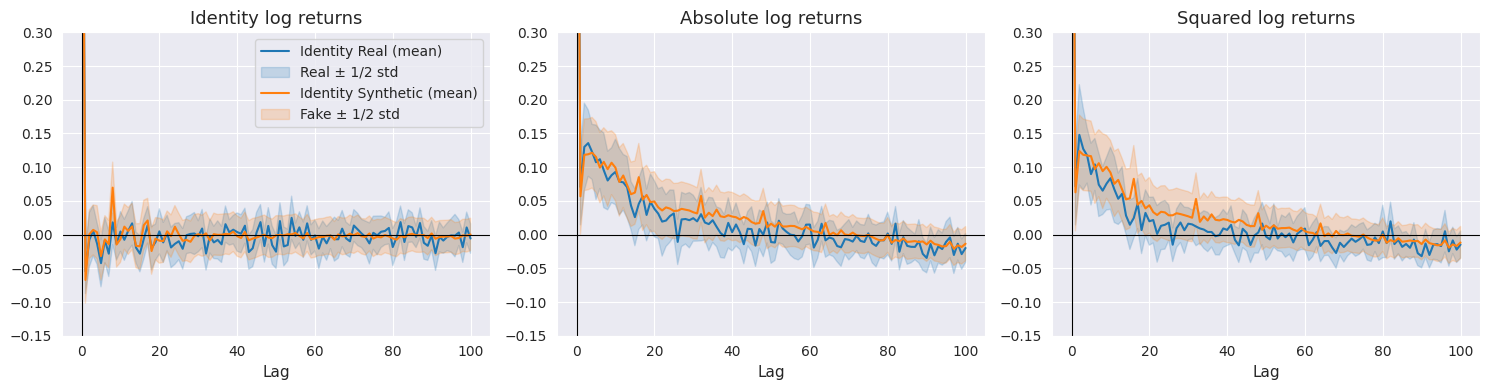

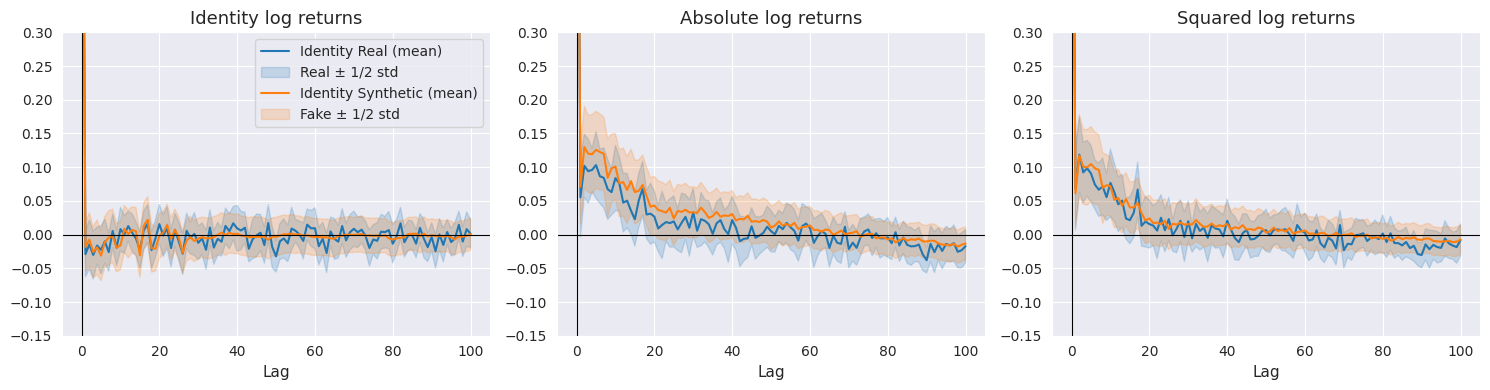

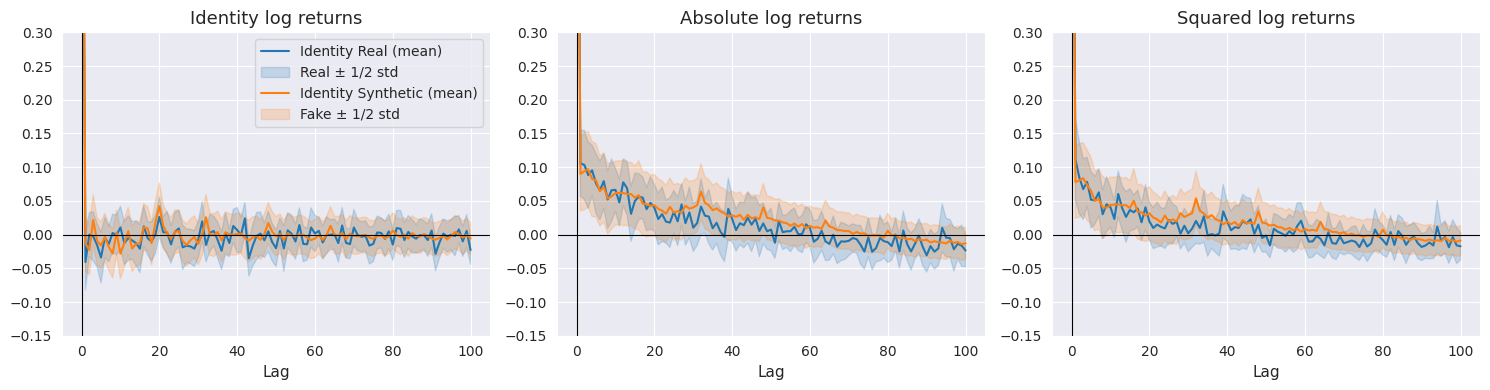

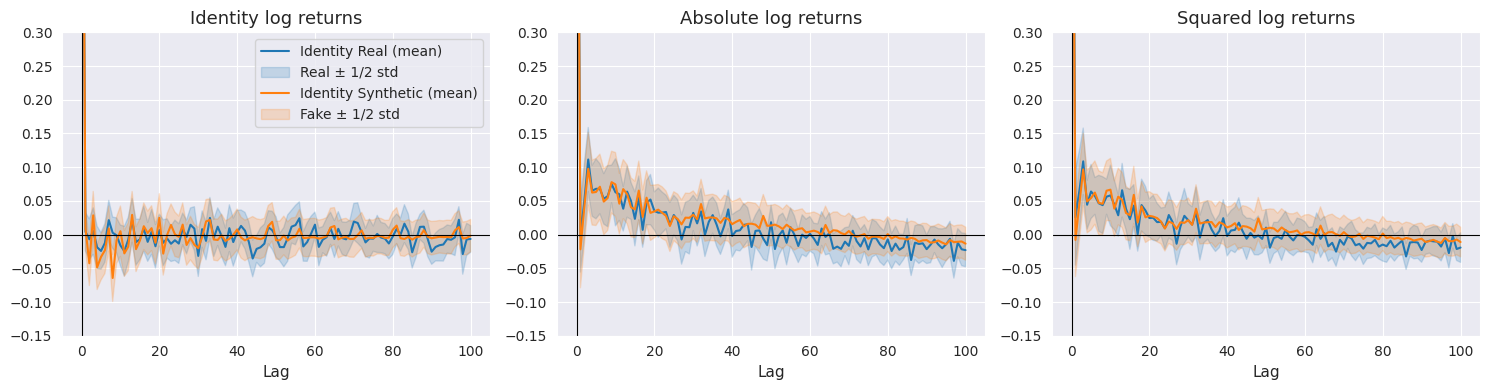

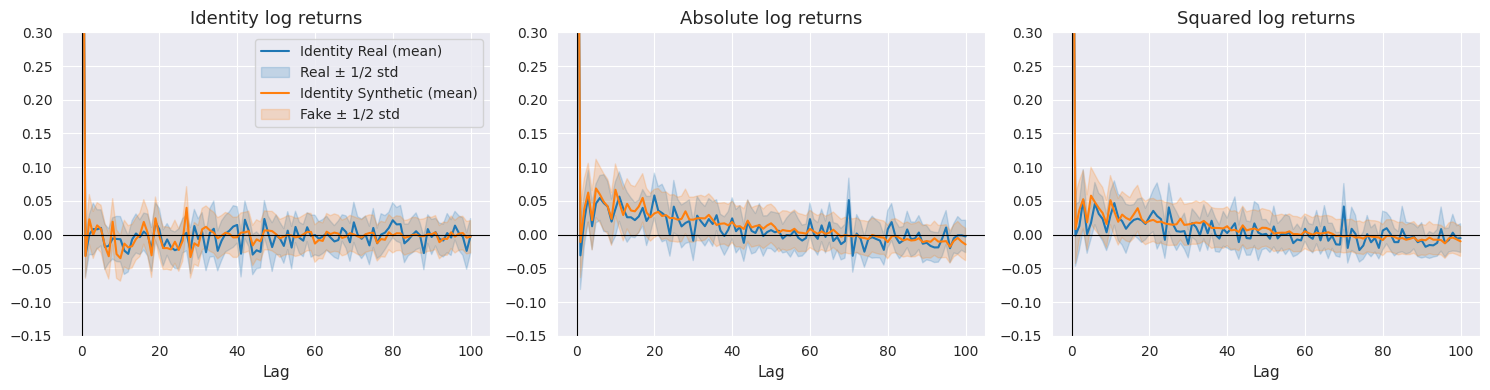

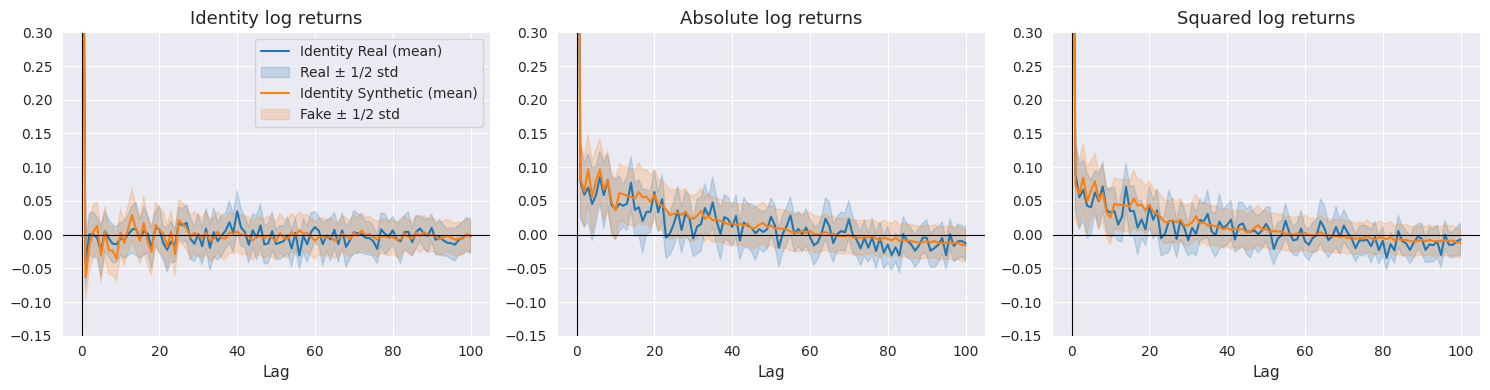

=== ACF Scores (per group) ===
Group 1:
  - Identity log returns: loss=0.0002
  - Absolute log returns: loss=0.0003
  - Squared log returns: loss=0.0006
Group 2:
  - Identity log returns: loss=0.0001
  - Absolute log returns: loss=0.0005
  - Squared log returns: loss=0.0002
Group 3:
  - Identity log returns: loss=0.0002
  - Absolute log returns: loss=0.0003
  - Squared log returns: loss=0.0003
Group 4:
  - Identity log returns: loss=0.0003
  - Absolute log returns: loss=0.0001
  - Squared log returns: loss=0.0001
Group 5:
  - Identity log returns: loss=0.0002
  - Absolute log returns: loss=0.0002
  - Squared log returns: loss=0.0002
Group 6:
  - Identity log returns: loss=0.0001
  - Absolute log returns: loss=0.0003
  - Squared log returns: loss=0.0003

=== Overall Average Scores ===
Identity log returns: mean of means=0.0002
Absolute log returns: mean of means=0.0003
Squared log returns: mean of means=0.0003


In [17]:
""" visualizing acf plots """
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf

def plot_acf_comparison_3cols(real_list, fake_list, n_vars, lags=50):
    """
    가로(1행)에 3개 컬럼:
      1) Identity
      2) Absolute
      3) Squared
    에 대해 ACF를 시각화하는 버전.
    
    real_list[i], fake_list[i]는 각각 i번째 자산(또는 그룹)에 대한 다수의 시계열 샘플을 갖고 있다고 가정.
    """
    # 변환 함수 정의 (3개)
    data_transforms = [
        (lambda x: x,       'Identity', 'Identity log returns'),
        (np.abs,            'Absolute', 'Absolute log returns'),
        (np.square,         'Squared',  'Squared log returns')
    ]
    
    for i in range(n_vars):
        # 한 그룹(자산)에 대해 1행 x 3열 서브플롯 생성
        fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
        
        # real_list[i], fake_list[i]는 각각 shape=(n_samples, length) 라고 가정
        # 변환 후 각 시계열에 대해 ACF를 계산하고, 평균/표준편차를 시각화
        
        for ax, (transform_func, data_type, title) in zip(axs, data_transforms):
            # (1) 변환 적용
            transformed_real = transform_func(real_list[i])
            transformed_fake = transform_func(fake_list[i])
            
            # (2) 각 시계열에 대해 ACF 계산
            acf_real = np.array([acf(ts, nlags=lags) for ts in transformed_real])
            acf_fake = np.array([acf(ts, nlags=lags) for ts in transformed_fake])
            
            # (3) 평균 ACF 및 표준편차
            mean_real = acf_real.mean(axis=0)
            std_real  = acf_real.std(axis=0)
            mean_fake = acf_fake.mean(axis=0)
            std_fake  = acf_fake.std(axis=0)
            
            # (4) 그래프 그리기
            ax.plot(mean_real, label=f'{data_type} Real (mean)', color='tab:blue')
            ax.fill_between(range(lags+1),
                            mean_real - 0.5*std_real,
                            mean_real + 0.5*std_real,
                            color='tab:blue', alpha=0.2,
                            label='Real ± 1/2 std')
            
            ax.plot(mean_fake, label=f'{data_type} Synthetic (mean)', color='tab:orange')
            ax.fill_between(range(lags+1),
                            mean_fake - 0.5*std_fake,
                            mean_fake + 0.5*std_fake,
                            color='tab:orange', alpha=0.2,
                            label='Fake ± 1/2 std')
            
            ax.set_ylim(-0.15, 0.3)
            ax.set_title(title, fontsize=13)
            ax.grid(True)
            ax.axhline(y=0, color='k', linewidth=0.8)
            ax.axvline(x=0, color='k', linewidth=0.8)
            ax.set_xlabel('Lag', fontsize=11)
        
        # 좌측 서브플롯에 범례를 표시 (첫 번째 col)
        axs[0].legend()
        
        # 필요 시 레이아웃 조정
        plt.tight_layout()
        plt.savefig(f"figure_acf{i}.png", dpi=300, bbox_inches='tight')
        plt.show()


# 사용 예시
plot_acf_comparison_3cols(real_list, fake_list, n_vars=config.n_vars, lags=100)
#plot_acf_comparison(real_list, fake_list, config.n_vars, lags=100)

import numpy as np
from statsmodels.tsa.stattools import acf

def calculate_acf_score_mean_vs_mean_no_std(
    real_list,
    fake_list,
    lags=30,
    loss_type='mse'
):
    """
    real_list[i], fake_list[i] 각각 하나의 "그룹" 또는 "자산" 집합이라고 가정
    각 real_list[i]에는 (n_real_samples_i, ) 형태의 시계열이 여러 개 들어있다고 보고,
    fake_list[i]에도 여러 시계열이 들어있다고 봄.

    -> Real 평균 ACF vs. Fake 평균 ACF만을 비교하여 MSE, MAE 등을 계산하는 버전.
       표준편차( std )는 따로 계산하지 않음.
    """
    # 변환 함수 정의
    data_transforms = [lambda x: x, np.abs, np.square]  
    titles = ['Identity log returns', 'Absolute log returns', 'Squared log returns']

    acf_scores = {}  # 그룹별 결과 저장
    # 최종적으로 transform별 "평균 점수(mean of means)"를 계산할 목적
    avg_scores_per_transform = {title: [] for title in titles}

    n_vars = len(real_list)
    for group_idx in range(n_vars):
        group_scores = {}  # 이 그룹에 대한 transform별 점수(스칼라값)

        for transform, title in zip(data_transforms, titles):
            # (1) Real / Fake 데이터 변환
            transformed_real = transform(real_list[group_idx])
            transformed_fake = transform(fake_list[group_idx])
            
            # (2) 각 샘플별 ACF 계산
            acf_real = np.array([acf(ts, nlags=lags) for ts in transformed_real])  
            acf_fake = np.array([acf(ts, nlags=lags) for ts in transformed_fake])  

            # (3) Real, Fake 각각의 평균 ACF 계산
            mean_acf_real = np.mean(acf_real, axis=0)  # shape=(lags+1,)
            mean_acf_fake = np.mean(acf_fake, axis=0)  # shape=(lags+1,)

            # (4) Real 평균 ACF vs. Fake 평균 ACF 차이
            diff = mean_acf_fake - mean_acf_real

            # (5) loss_type에 따라 계산 (MSE or MAE 등)
            if loss_type == 'mse':
                val = np.mean(diff**2)
            elif loss_type == 'mae':
                val = np.mean(np.abs(diff))
            else:
                raise ValueError(f"Unknown loss_type: {loss_type}")

            # (6) 표준편차는 사용하지 않으므로, 결과는 스칼라 val만
            group_scores[title] = round(val, 4)

            # (7) 전체 평균 계산을 위해 저장
            avg_scores_per_transform[title].append(val)

        # 해당 그룹에 대한 transform별 점수 기록
        acf_scores[f"Group {group_idx+1}"] = group_scores
    
    # 모든 그룹에 대한 “평균의 평균”(mean of means) 계산
    overall_average_scores = {}
    for title in titles:
        mean_of_means = np.mean(avg_scores_per_transform[title])
        overall_average_scores[title] = round(mean_of_means, 4)

    return acf_scores, overall_average_scores


# 사용 예시
lags = 40
loss_type = 'mse'  # 'mse', 'mae' 등

acf_scores, overall_avg_scores = calculate_acf_score_mean_vs_mean_no_std(
    real_list, 
    fake_list, 
    lags=lags, 
    loss_type=loss_type
)

print("=== ACF Scores (per group) ===")
for group_name, transform_scores in acf_scores.items():
    print(f"{group_name}:")
    for transform_title, val in transform_scores.items():
        print(f"  - {transform_title}: loss={val}")

print("\n=== Overall Average Scores ===")
for transform_title, mean_of_means in overall_avg_scores.items():
    print(f"{transform_title}: mean of means={mean_of_means}")


[Correlation Loss - MAE]
Loss: 0.0211

[Correlation Loss - Frobenius]
Loss: 0.1602

[Correlation Loss - MSE]
Loss: 0.0007


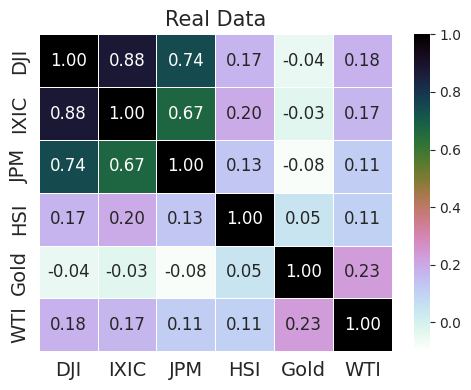

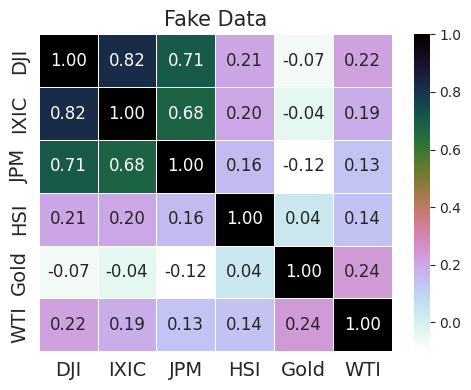

In [18]:
def correlation_mean(data):
    """
    각 샘플의 상관행렬을 계산한 후, 그 평균을 반환.
    
    Parameters:
        data (np.ndarray): shape = (num_samples, num_time_steps, num_features)
    
    Returns:
        mean_correlation_matrix (np.ndarray): shape = (num_features, num_features)
    """
    num_samples = data.shape[0]
    correlations = []

    for i in range(num_samples):
        sample = data[i]  # shape = (num_time_steps, num_features)
        corr_mat = np.corrcoef(sample, rowvar=False)
        correlations.append(corr_mat)

    mean_correlation_matrix = np.mean(correlations, axis=0)  
    return mean_correlation_matrix


def correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mse'):
    """
    Real과 Fake의 평균 상관행렬 간의 손실을 계산.
    
    Parameters:
        real_mean_corr (np.ndarray): Real 데이터의 평균 상관행렬
        fake_mean_corr (np.ndarray): Fake 데이터의 평균 상관행렬
        loss_type (str): 'mse', 'mae', 'frobenius' 중 선택

    Returns:
        loss (float): 지정된 손실 타입에 따른 손실 값 (소수점 4자리로 반올림)
    """
    diff = fake_mean_corr - real_mean_corr

    if loss_type == 'mse':
        loss_val = np.mean(diff**2)
    elif loss_type == 'mae':
        loss_val = np.mean(np.abs(diff))
    elif loss_type == 'frobenius':            
        loss_val = np.linalg.norm(diff, ord='fro')
    else:
        raise ValueError(f"Unsupported loss_type: {loss_type}")

    return round(loss_val, 4)

# 상관행렬 계산을 위해 데이터 전치 (shape: (num_samples, num_time_steps, num_features))
real_mean_corr = correlation_mean(np.transpose(real_data, (0, 2, 1)))
fake_mean_corr = correlation_mean(np.transpose(fake_data, (0, 2, 1)))

# 손실 계산
loss_mae = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mae')
loss_frob = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='frobenius')
loss_mse = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mse')

# 결과 출력
print("[Correlation Loss - MAE]")
print(f"Loss: {loss_mae}")

print("\n[Correlation Loss - Frobenius]")
print(f"Loss: {loss_frob}")

print("\n[Correlation Loss - MSE]")
print(f"Loss: {loss_mse}")


def plot_correlation_heatmap(correlation_matrix, title, feature_names):
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(correlation_matrix, annot=True, cmap='cubehelix_r', linewidths=.5, ax=ax, fmt=".2f", annot_kws={"size": 12}, vmin=-0.1, vmax=1)
    
    # 축 이름 설정
    ax.set_xticklabels(feature_names, fontsize=12)
    ax.set_yticklabels(feature_names, fontsize=12)
    
    # 제목 및 시각적 요소
    ax.set_title(title, fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()
    plt.show()

feature_names = ['DJI', 'IXIC', 'JPM', 'HSI', 'Gold', 'WTI']
plot_correlation_heatmap(real_mean_corr, "Real Data", feature_names)
plot_correlation_heatmap(fake_mean_corr, "Fake Data", feature_names)


0.0211


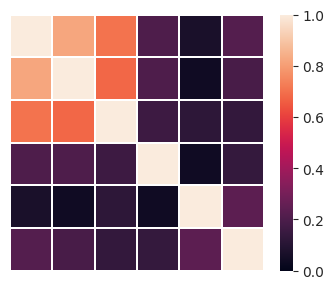

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

def plot_correlation_heatmap(corr_mat, loss):
    fig, ax = plt.subplots(figsize=(3.5,3))

    sns.heatmap(
        np.abs(corr_mat),
        cmap='rocket',
        vmin=0, vmax=1,
        linewidths=0.01,
        linecolor="white",
        ax=ax
    )

    # ticks & spines off
    ax.set_xticks([]); ax.set_yticks([])
    for s in ax.spines.values(): s.set_visible(False)

    # loss 숫자만 위쪽에
    # ax.text(0.5, 1.02, f"{loss:.3f}",
    #         ha="center", va="bottom", transform=ax.transAxes,
    #         fontsize=14)

    plt.tight_layout()
    plt.savefig("fig_corr_Proposed.png", dpi=300, bbox_inches='tight')
    plt.show()
    


# 예시
real_loss = 0.000
fake_loss = correlation_loss(real_mean_corr, fake_mean_corr, loss_type='mae')
print(fake_loss)
#plot_correlation_heatmap(real_mean_corr, real_loss)
plot_correlation_heatmap(fake_mean_corr, fake_loss)


In [20]:
import numpy as np
from statsmodels.tsa.stattools import ccf

def ccf_single_sample(x, max_lag=10):
    """
    x: shape = (time_steps, features)
    - statsmodels.tsa.stattools.ccf(x[:, i], x[:, j])를 이용해
      i, j 모든 쌍에 대해 lag=0..max_lag 범위의 cross-correlation을 구한다.
    - 결과를 3D 배열 (features, features, max_lag+1)에 저장하여 반환.

    Returns
    -------
    cc_matrix: np.ndarray
      shape = (num_features, num_features, max_lag+1)
      cc_matrix[i, j, k] = ccf 결과에서 lag=k인 상관계수
    """
    time_steps, num_features = x.shape
    cc_matrix = np.zeros((num_features, num_features, max_lag+1), dtype=float)

    for i in range(num_features):
        for j in range(num_features):
            # statsmodels ccf: lag >= 0 에 대한 상관계수
            c_array = ccf(x[:, i], x[:, j], adjusted=False)
            # lag=0 ~ max_lag만 추출
            c_array = c_array[:(max_lag+1)]
            # ccf 함수는 무한대로 확장될 수 있으므로, 필요한 max_lag+1까지만 자르기
            if len(c_array) < (max_lag+1):
                # 부족한 경우 0으로 채우기
                c_array = np.pad(c_array, (0, max_lag+1 - len(c_array)), 'constant')
            cc_matrix[i, j, :] = c_array

    return cc_matrix

def ccf_mean(data, max_lag=20):
    """
    data: shape = (num_samples, time_steps, features)

    각 샘플마다 ccf_single_sample -> (features, features, max_lag+1)
    모든 샘플에 대해 평균낸 결과를 반환.

    Returns
    -------
    mean_ccf: np.ndarray
      shape = (num_features, num_features, max_lag+1)
    """
    num_samples, time_steps, num_features = data.shape

    # 모든 샘플의 CCF 결과를 쌓아두기
    all_cc = np.zeros((num_samples, num_features, num_features, max_lag+1), dtype=float)

    for s_idx in range(num_samples):
        cc_matrix = ccf_single_sample(data[s_idx], max_lag=max_lag)
        all_cc[s_idx] = cc_matrix  # shape=(features, features, max_lag+1)

    # 샘플 차원에 대해 평균
    mean_ccf = all_cc.mean(axis=0)  # shape=(features, features, max_lag+1)
    return mean_ccf

def ccf_loss_mean_vs_mean(real_mean_ccf, fake_mean_ccf, loss_type='mse'):
    """
    - real_mean_ccf: shape = (features, features, max_lag+1)
      Real 데이터의 평균 CCF 행렬
    - fake_mean_ccf: shape = (features, features, max_lag+1)
      Fake 데이터의 평균 CCF 행렬
    - loss_type: 'mse', 'mae', 'frobenius' 중 선택

    returns: loss (float), 소수점 4자리로 반올림
    """
    # 두 평균 CCF 행렬의 차이
    diff = fake_mean_ccf - real_mean_ccf

    # 손실 계산
    if loss_type == 'mse':
        loss_val = np.mean(diff**2)
    elif loss_type == 'mae':
        loss_val = np.mean(np.abs(diff))
    elif loss_type == 'frobenius':
        # 3D 배열에 대한 Frobenius norm
        loss_val = np.linalg.norm(diff)
    else:
        raise ValueError(f"Unsupported loss_type: {loss_type}")

    return round(loss_val, 4)

# 사용 예시
max_lag = 10

# CCF 계산을 위해 데이터 전치 (shape: (num_samples, time_steps, num_features))
# 기존에 사용된 np.transpose(real_data, (0, 2, 1))은 이미 올바른 형상으로 가정
real_mean_ccf = ccf_mean(np.transpose(real_data, (0, 2, 1)), max_lag=max_lag)
fake_mean_ccf = ccf_mean(np.transpose(fake_data, (0, 2, 1)), max_lag=max_lag)

# 손실 계산
loss_mae = ccf_loss_mean_vs_mean(real_mean_ccf, fake_mean_ccf, loss_type='mae')
loss_frob = ccf_loss_mean_vs_mean(real_mean_ccf, fake_mean_ccf, loss_type='frobenius')
loss_mse = ccf_loss_mean_vs_mean(real_mean_ccf, fake_mean_ccf, loss_type='mse')

# 결과 출력
print("[Partial CCF Loss - MAE]")
print(f"Loss: {loss_mae}")

print("\n[Partial CCF Loss - Frobenius]")
print(f"Loss: {loss_frob}")

print("\n[Partial CCF Loss - MSE]")
print(f"Loss: {loss_mse}")


[Partial CCF Loss - MAE]
Loss: 0.0213

[Partial CCF Loss - Frobenius]
Loss: 0.7757

[Partial CCF Loss - MSE]
Loss: 0.0015


In [21]:
def leverage_effect_loss_mean_vs_mean(real_list, fake_list, lags=30, loss_type='mse'):
    """
    Real 데이터의 평균 레버리지 효과와 Fake 데이터의 평균 레버리지 효과를 비교하여 손실을 계산.

    Parameters:
        real_list (list of np.ndarray): 각 그룹별 Real 데이터. 각 요소는 shape=(n_real_samples, time_length)
        fake_list (list of np.ndarray): 각 그룹별 Fake 데이터. 각 요소는 shape=(n_fake_samples, time_length)
        lags (int): 최대 시차 (tau) 값
        loss_type (str): 손실 함수의 종류 ('mse', 'mae', 'fro')

    Returns:
        leverage_scores (dict): 그룹별 손실 값 저장
        overall_mean (float): 모든 그룹의 평균 손실
    """

    def leverage_effect(ts, tau):
        """
        레버리지 효과 계산:
        Corr(r_t, r_(t+tau)^2)
        """
        rt = ts[:-tau]            # 뒤에서 tau 개 제외
        rt_squared = ts[tau:]**2  # 앞에서 tau 개 제외한 뒤 제곱
        return np.corrcoef(rt, rt_squared)[0, 1]  # 상관계수

    n_vars = len(real_list)
    leverage_scores = {}     # 그룹별 손실 값 저장
    all_group_losses = []    # 모든 그룹의 손실 값을 모아 전체 평균 손실 계산

    for i in range(n_vars):
        real_data = real_list[i]  # shape=(n_real_samples, time_length)
        fake_data = fake_list[i]  # shape=(n_fake_samples, time_length)

        # (1) Real 각 샘플의 레버리지 효과 (tau=1부터 lags까지)
        real_leverage_effects = np.array([
            [leverage_effect(ts, tau) for tau in range(1, lags+1)]
            for ts in real_data
        ])  # shape = (n_real_samples, lags)

        # (2) Fake 각 샘플의 레버리지 효과
        fake_leverage_effects = np.array([
            [leverage_effect(ts, tau) for tau in range(1, lags+1)]
            for ts in fake_data
        ])  # shape = (n_fake_samples, lags)

        # (3) Real의 평균 레버리지 효과 계산
        mean_real_leverage = np.mean(real_leverage_effects, axis=0)  # shape=(lags,)

        # (4) Fake의 평균 레버리지 효과 계산
        mean_fake_leverage = np.mean(fake_leverage_effects, axis=0)  # shape=(lags,)

        # (5) Real 평균과 Fake 평균 간의 차이 계산
        diff = mean_fake_leverage - mean_real_leverage

        # (6) loss_type에 따라 손실 계산
        if loss_type == 'mse':
            loss_val = np.mean(diff**2)
        elif loss_type == 'mae':
            loss_val = np.mean(np.abs(diff))
        elif loss_type == 'frobenius':
            loss_val = np.linalg.norm(diff)
        else:
            raise ValueError(f"Unsupported loss_type: {loss_type}")

        # (7) 손실 값 저장 (소수점 반올림은 최종 저장 시점에 적용)
        leverage_scores[f'Group {i+1}'] = loss_val
        all_group_losses.append(loss_val)

        # (8) 그룹별 손실 출력 (소수점 반올림)
        print(f"[Group {i+1}] Leverage Loss ({loss_type.upper()}) => {loss_val:.4f}")

    # (9) 전체 그룹의 평균 손실 계산
    overall_mean = np.mean(all_group_losses)
    print(f"\n[Overall] Leverage Loss ({loss_type.upper()}) => {overall_mean:.4f}")

    # (10) 최종 결과를 소수점 4자리로 반올림하여 저장
    for group in leverage_scores:
        leverage_scores[group] = round(leverage_scores[group], 4)
    overall_mean = round(overall_mean, 4)

    return leverage_scores, overall_mean

# 예시 사용

# 손실 계산 (예: 'mse', 'mae', 'frobenius' 중 선택)
loss_type = 'mse'  # 'mse', 'mae', 'frobenius'
lags = 40
leverage_scores, overall_mean = leverage_effect_loss_mean_vs_mean(
    real_list, 
    fake_list, 
    lags=lags, 
    loss_type=loss_type
)

# 최종 결과 출력
print("\n=== Leverage Effect Loss (Mean vs. Mean) ===")
for group, loss in leverage_scores.items():
    print(f"{group}: {loss}")
print(f"Overall Mean Loss: {overall_mean}")

[Group 1] Leverage Loss (MSE) => 0.0003
[Group 2] Leverage Loss (MSE) => 0.0002
[Group 3] Leverage Loss (MSE) => 0.0002
[Group 4] Leverage Loss (MSE) => 0.0002
[Group 5] Leverage Loss (MSE) => 0.0002
[Group 6] Leverage Loss (MSE) => 0.0002

[Overall] Leverage Loss (MSE) => 0.0002

=== Leverage Effect Loss (Mean vs. Mean) ===
Group 1: 0.0003
Group 2: 0.0002
Group 3: 0.0002
Group 4: 0.0002
Group 5: 0.0002
Group 6: 0.0002
Overall Mean Loss: 0.0002


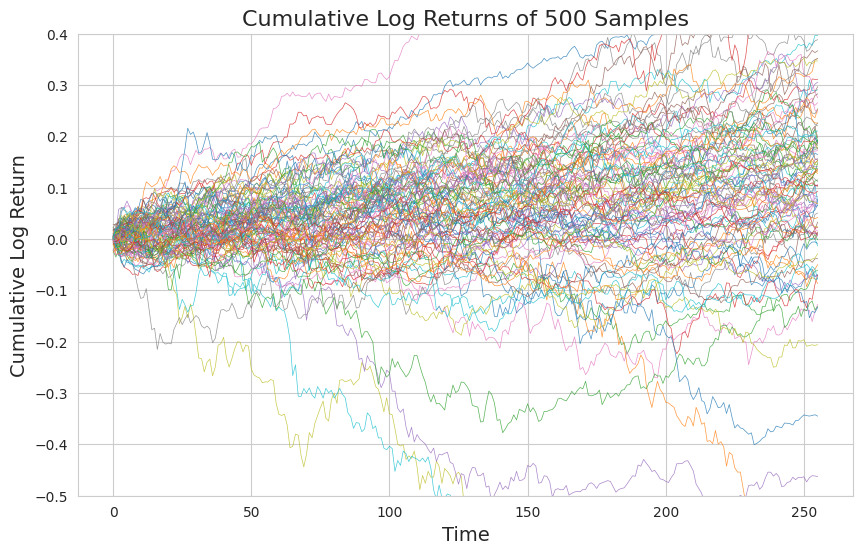

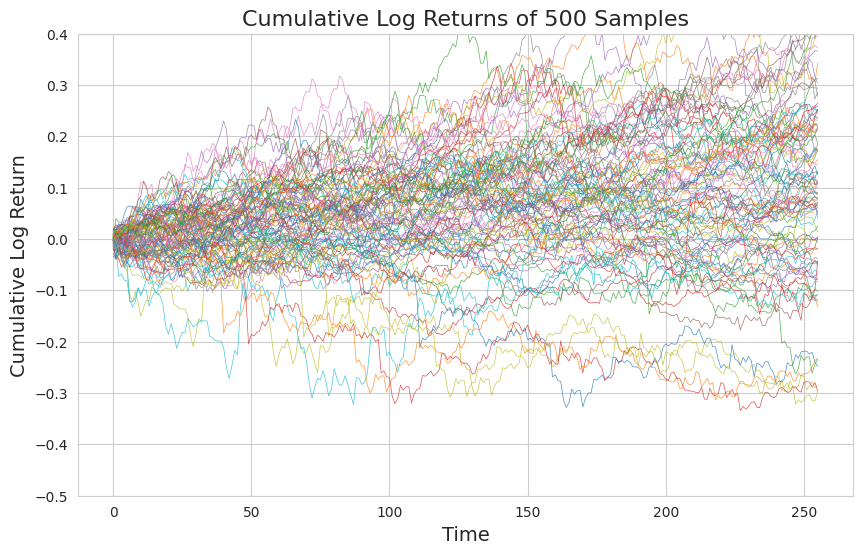

In [26]:
import matplotlib.pyplot as plt
import numpy as np

# fake_data: (10000, 1, 754)
# 데이터를 squeeze하여 2D 배열로 변환
idx = 4
fake_data_new = fake_data[:, idx, :].squeeze()  # shape: (10000, 754)

# 누적 로그 리턴 계산
cumulative_returns = np.cumsum(fake_data_new[:100], axis=1)  # 첫 10개 샘플에 대해 누적합 계산

# 그래프 그리기
plt.figure(figsize=(10, 6))
for i, cum_return in enumerate(cumulative_returns):
    plt.plot(cum_return, label=f'Sample {i+1}', alpha=0.8, linewidth=0.5)  # 각 샘플의 누적 로그 리턴을 그리기

# 그래프 설정
plt.title("Cumulative Log Returns of 500 Samples", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Cumulative Log Return", fontsize=14)
#plt.legend(loc="best", fontsize=12)
plt.ylim(-0.5, 0.4)  # <-- 동일 범위로 맞춤
plt.grid(True)
plt.show()

# fake_data: (10000, 1, 754)
# 데이터를 squeeze하여 2D 배열로 변환
real_data_new = real_data[:, idx, :].squeeze()  # shape: (10000, 754)
perm_idx = np.random.permutation(real_data_new.shape[0])[:1000]
real_data_new = real_data_new[perm_idx]
# 누적 로그 리턴 계산
cumulative_returns = np.cumsum(real_data_new[:100], axis=1)  # 첫 10개 샘플에 대해 누적합 계산

# 그래프 그리기
plt.figure(figsize=(10, 6))
for i, cum_return in enumerate(cumulative_returns):
    plt.plot(cum_return, label=f'Sample {i+1}', alpha=0.8, linewidth=0.5)  # 각 샘플의 누적 로그 리턴을 그리기

# 그래프 설정
plt.title("Cumulative Log Returns of 500 Samples", fontsize=16)
plt.xlabel("Time", fontsize=14)
plt.ylabel("Cumulative Log Return", fontsize=14)
#plt.legend(loc="best", fontsize=12)
plt.grid(True)
plt.ylim(-0.5, 0.4)  # <-- 동일 범위로 맞춤
plt.show()

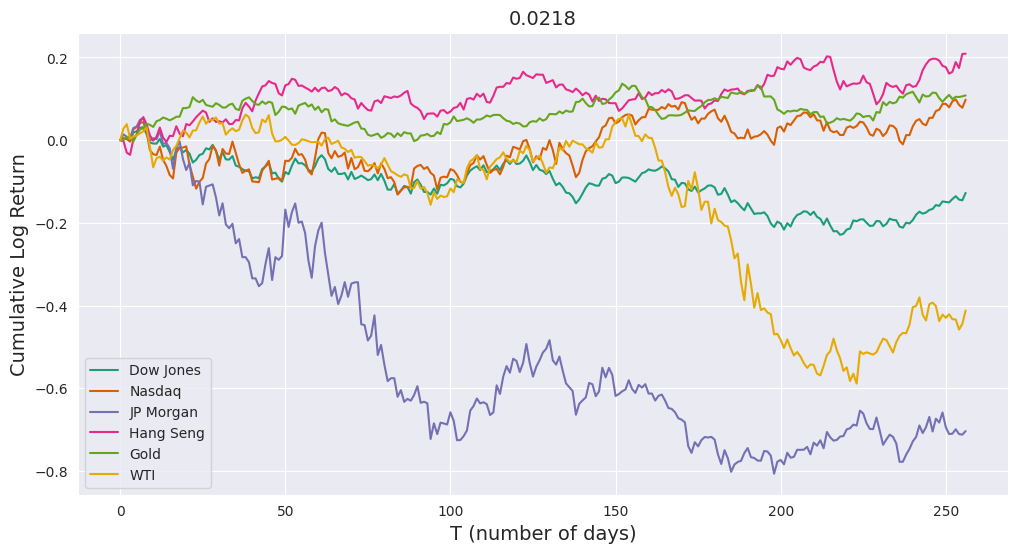

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("darkgrid")

# 실제 데이터 평균 상관관계 행렬 (주어진 변수)
real_mean_corr  # (6,6) shape

# fake_data (samples, assets, length)
n_samples, n_assets, seq_length = fake_data.shape
custom_palette = sns.color_palette("Dark2", n_assets)

# 각 샘플의 MAE 계산 후 가장 낮은 MAE 샘플 선정
mae_values = []
a = 300
for i in range(a, a+500):
    fake_sample = fake_data[i]  # shape: (n_assets, seq_length)
    fake_corr = np.corrcoef(fake_sample)
    mae = np.mean(np.abs(fake_corr - real_mean_corr))
    mae_values.append(mae)

# 가장 낮은 MAE 가진 샘플 선정
best_sample_idx = np.argmin(mae_values)
best_sample_mae = mae_values[best_sample_idx]
best_sample = fake_data[best_sample_idx]

# 누적 로그 리턴 계산 (시작점 0으로 설정)
cumulative_returns = np.cumsum(best_sample, axis=1)
cumulative_returns = np.hstack((np.zeros((n_assets, 1)), cumulative_returns))

# 자산 레이블 설정 (임의로 설정, 실제 자산명으로 변경 가능)
asset_labels = ['Dow Jones', 'Nasdaq', 'JP Morgan', 'Hang Seng', 'Gold', 'WTI']

# 플롯 시각화
plt.figure(figsize=(12, 6))
for asset_idx in range(n_assets):
    plt.plot(cumulative_returns[asset_idx], linewidth=1.5, label=asset_labels[asset_idx], color=custom_palette[asset_idx])

plt.xlabel("T (number of days)", fontsize=14)
plt.ylabel("Cumulative Log Return", fontsize=14)
plt.grid(True)
plt.legend(loc='best')
plt.title(f"{best_sample_mae:.4f}", fontsize=14)
plt.savefig('figure_MTS_low_proposed.png', dpi=300, bbox_inches='tight')
plt.show()


In [24]:
# """ 누적 로그 리턴 플롯 """
# def compute_cumulative_log_returns(data):
#     return np.cumsum(data, axis=2)  # Cumulative sum along the time axis

# # 누적 로그 리턴 계산
# real_cumulative_log_returns = compute_cumulative_log_returns(real_data)  # Shape: (batch_size, num_assets, sequence_length)
# fake_cumulative_log_returns = compute_cumulative_log_returns(fake_data)  # Shape: (batch_size, num_assets, sequence_length)

# # 각 자산별 플롯 생성
# num_assets = real_data.shape[1]
# for asset_idx in range(num_assets):
#     # Real 데이터 플롯
#     plt.figure(figsize=(12, 6))
#     for i in range(real_cumulative_log_returns.shape[0]):  # 최대 10개의 샘플만 플롯
#         plt.plot(real_cumulative_log_returns[i, asset_idx, :], alpha=0.6)
#     plt.title(f'Real Cumulative Log Returns for Asset {asset_idx + 1}')
#     plt.xlabel('Time Step')
#     plt.ylabel('Cumulative Log Return')
#     plt.grid(True)
#     plt.show()

#     # Fake 데이터 플롯
#     plt.figure(figsize=(12, 6))
#     for i in range(fake_cumulative_log_returns.shape[0]):  # 최대 10개의 샘플만 플롯
#         plt.plot(fake_cumulative_log_returns[i, asset_idx, :], alpha=0.6)
#     plt.title(f'Fake Cumulative Log Returns for Asset {asset_idx + 1}')
#     plt.xlabel('Time Step')
#     plt.ylabel('Cumulative Log Return')
#     plt.grid(True)
#     plt.show()

### Synthetic data generation

### Model evaluation

We compute the performance of our model by first generating the price process, apply the prespecified trading strategies and compare the resulting PnL process using the real and fake data.

In [25]:
from src.evaluation.strategies import log_return_to_price

eval_size = real_data.shape[0]
#eval_size = 1500
#real_data = test_data_org.transpose(1,2).cpu().numpy()
fake_data_torch = torch.from_numpy(fake_data).float().transpose(1, 2)
real_data_torch = torch.from_numpy(real_data).float().transpose(1, 2)

test_init_price = train_init_price
test_init_price[:] = 100

fake_prices = log_return_to_price(fake_data_torch[:eval_size], test_init_price[:eval_size])
real_prices = log_return_to_price(real_data_torch[:eval_size], test_init_price[:eval_size])

RuntimeError: The expanded size of the tensor (3000) must match the existing size (4153) at non-singleton dimension 0.  Target sizes: [3000, 6].  Tensor sizes: [4153, 6]

In [ ]:
config_dir = 'src/evaluation/config.yaml'
with open(config_dir) as file:
    eval_config = ml_collections.ConfigDict(yaml.safe_load(file))

print(fake_data_torch.shape, real_data_torch.shape, test_init_price.shape)

all_positive = (fake_prices > 0).all()
if not all_positive:
    raise ValueError("Sanity Check Failed: Some fake prices are not positive.")

# 누적하기 위한 딕셔너리(평균 낼 것들이면 0.으로 초기화)
res_dict = {
    "var_abs_mean": 0.,
    "var_rel_mean": 0.,
    "es_abs_mean": 0.,
    "es_rel_mean": 0.,
}

num_strat = 4  # 전략 개수

with torch.no_grad():
    for strat_name in ['equal_weight', 'mean_reversion', 'trend_following', 'vol_trading']:
    #for strat_name in ['equal_weight', 'trend_following']:
        # 각 전략에 대해 평가 함수 호출
        subres_dict = full_evaluation(fake_prices, real_prices, eval_config, strat_name=strat_name)

        # subres_dict에서 *_mean 항목만 골라서 소수점 4자리 반올림
        filtered_means = {
            k: round(v, 4) for k, v in subres_dict.items() if '_mean' in k
        }
        print(f"{strat_name}: {filtered_means}")

        # res_dict에 누적
        for k in res_dict:
            # subres_dict가 해당 키를 갖고 있다고 가정
            res_dict[k] += subres_dict[k] / num_strat

# 최종적으로 각 키에 대해 평균화된 값 출력
for k, v in res_dict.items():
    print(k, round(v, 4))

### T-sne

In [ ]:
# from src.evaluation.strategies import log_return_to_price

# #eval_size = real_data.shape[0]
# eval_size = 1600
# real_data = test_data_org.transpose(1,2).cpu().numpy()
# fake_data_torch = torch.from_numpy(fake_data).float().transpose(1, 2)
# real_data_torch = torch.from_numpy(real_data).float().transpose(1, 2)

# test_init_price = train_init_price
# #test_init_price[:] = 100

# fake_prices = log_return_to_price(fake_data_torch[:eval_size], test_init_price[:eval_size])
# real_prices = log_return_to_price(real_data_torch[:eval_size], test_init_price[:eval_size])

In [ ]:
# from src.evaluations.plot import *
# from src.evaluations.evaluations import *
    
# # 1) numpy array를 torch.Tensor로 변환
# real_tensor = torch.from_numpy(real_data).float()[:1600, :, :24]   # torch.Size([1602, 6, 256])
# fake_tensor = torch.from_numpy(fake_data).float()[:1600, :, :24]   # torch.Size([3000, 6, 256])

# # 2) TensorDataset & DataLoader 생성
# real_ds = TensorDataset(real_tensor)
# real_test_dl = DataLoader(real_ds, batch_size=128, shuffle=False)

# fake_ds = TensorDataset(fake_tensor)
# fake_test_dl = DataLoader(fake_ds, batch_size=128, shuffle=False)


# tsne_plot(real_test_dl,fake_test_dl,config,plot_show =True)

In [ ]:
# discriminative_score,_ = compute_discriminative_score(
#             real_test_dl, real_test_dl, fake_test_dl, fake_test_dl, config, 10, 1, epochs=30, batch_size=128)

In [ ]:
# p_score_mean, _ = compute_predictive_score(
#             real_train_dl, real_test_dl, fake_train_dl, fake_test_dl, config, 32, 2, epochs=50, batch_size=128)